# Example SFRmaker workflow
* requires packages listed at <https://github.com/aleaf/SFRmaker>  
(scroll down to **Dependencies**: preproc, postproc and diagnostics)

In [1]:
import sys
# if preproc.py and postproc.py are in a different folder from this script,
# add that folder to the path so python can find it
sys.path.append('../')
sys.path.append('../../flopy/')
import time

import numpy as np
import pandas as pd
from shapely.geometry import box
import matplotlib.pyplot as plt
import flopy
from flopy.utils.reference import SpatialReference
from GISio import df2shp, shp2df
from rasterstats import zonal_stats
from preproc import NHDdata
from postproc import SFRdata

%matplotlib inline

### SFRmaker input

In [2]:
# shapefiles defining the model grid, and the area that will include SFR
mf_grid = 'data/grid.shp'
mf_domain = 'data/domain.shp'

# NHDPlus input files (see the input requirements in the SFRmaker readme file
# (Note that multiple datasets can be supplied as lists;
# when the SFR area covers multiple drainage basins)
pfvaa_files = ['data/PlusFlowlineVAA.dbf']
plusflow_files = ['data/PlusFlow.dbf']
elevslope_files = ['data/elevslope.dbf']
flowlines = ['data/NHDFlowlines.shp']

# dem used for streambed elevations
dem = 'data/dem.tif'
dem_units_mult = 1. # convert dem elevation units to modflow units

## Set up the modflow model first

### grid location and discretization

In [3]:
xul, yul = 682668.5, 5147586.7 # UTM zone 15 N, nad27 meters (epsg code 26715)
nrow, ncol = 100, 160
dxdy = 250 # ft
delr = np.ones(nrow) * dxdy
delc = np.ones(ncol) * dxdy

### set up in flopy and export the grid to a shapefile

In [4]:
m = flopy.modflow.Modflow('example', model_ws='data')
dis = flopy.modflow.ModflowDis(m, nlay=1, nrow=nrow, ncol=ncol, delr=delc, delc=delr)
m.sr = SpatialReference(delr=m.dis.delr * .3048, delc=m.dis.delc * .3048, xul=682668.5, yul=5147586.7, 
                        proj4_str='EPSG:26715', rotation=0)
m.dis.export('data/grid.shp')

### Sample elevations from the DEM using ```zonal_stats``` (```rasterstats``` package)

In [5]:
elevations = zonal_stats('data/grid.shp', 'data/dem.tif')

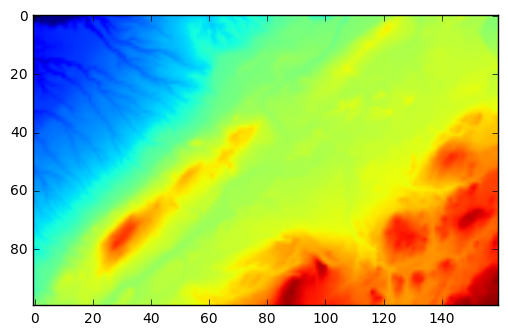

In [6]:
dem_mean = np.reshape([z['mean'] for z in elevations], (nrow, ncol))
plt.imshow(dem_mean)

### Set the model top elevations to the mean DEM value in each cell

In [7]:
dis = flopy.modflow.ModflowDis(m, nlay=1, nrow=nrow, ncol=ncol, delr=delc, delc=delr,
                              top=dem_mean, botm=dem_mean-100.)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfdis.ModflowDis'> <class 'flopy.modflow.mfdis.ModflowDis'>
replacing existing Package...


In [8]:
m.write_input()

### make a shapefile of the active model domain  
(can be any area inside the grid; for this example set to extent of grid)

In [9]:
yll = yul - nrow * dxdy * .3048
xlr = xul + ncol * dxdy * .3048
domain = box(xul, yll, xlr, yul)
domain
df2shp(pd.DataFrame({'geometry':[domain]}), 'data/domain.shp', epsg=26715)

writing data/domain.shp...


## Running SFRmaker

### Initialize an NHDdata object  
* ```to_sfr`` performs the basic transfer of information to the grid, setting up the tables **Mat1** (reach data) and **Mat2** (segment data)

In [10]:
nhd = NHDdata(NHDFlowline=flowlines, PlusFlowlineVAA=pfvaa_files, PlusFlow=plusflow_files,
              elevslope=elevslope_files,
              mf_grid=mf_grid, mf_units='feet',
              model_domain=mf_domain)

# Setup the segments, reaches, and other basic SFR parameters
nhd.to_sfr()

Reading input...

reading data/PlusFlowlineVAA.dbf...
--> building dataframe... (may take a while for large shapefiles)

reading data/PlusFlow.dbf...
--> building dataframe... (may take a while for large shapefiles)

reading data/elevslope.dbf...
--> building dataframe... (may take a while for large shapefiles)

reading data/grid.shp...
--> building dataframe... (may take a while for large shapefiles)
+proj=utm +zone=15 +datum=NAD27 +units=m +no_defs 
+proj=longlat +datum=NAD83 +no_defs 
(-90.62437904647767, 46.38709783343725, -90.46278092845638, 46.45901882393651)

reading data/NHDFlowlines.shp...
--> building dataframe... (may take a while for large shapefiles)
reprojecting NHDFlowlines from
+proj=longlat +datum=NAD83 +no_defs 
to
+proj=utm +zone=15 +datum=NAD27 +units=m +no_defs ...

clipping flowlines to active area...
intersecting flowlines with grid cells...

Building spatial index...


..\preproc.py:357: NodeIndexWarning: 
  warnings.warn(NodeIndexWarning(mf_grid))


finished in 1.98s

Intersecting 17 features...
17
finished in 0.14s

setting up segments... (may take a few minutes for large networks)
getting routing information from NHDPlus Plusflow table...
assigning segment numbers...
finished in 0.09s

setting up reaches and Mat1... (may take a few minutes for large grids)
finished in 0.52s

computing widths...
multiplying length units by 3.280839895013123 to convert from GIS to MODFLOW...

setting up Mat2...
finished in 0.00s

enforcing best segment numbering...

Done creating SFR dataset.


### Mat1

In [11]:
nhd.m1.head()

,comid,geometry,node,reach,segment,reachID,length,asum,width,roughness,sbthick,sbK,sbtop,layer,outseg,ReachID
861,1815711,LINESTRING Z (694812.4654326627 5141215.339349...,13440,1,1,862,95.168027,0.018585,0.519135,0.037,1,1,0,1,4,1
862,1815711,LINESTRING Z (694784.318359375 5141208.3278759...,13439,2,1,863,259.723954,0.072670,1.031039,0.037,1,1,0,1,4,2
863,1815711,LINESTRING Z (694708.1181640625 5141215.231313...,13438,3,1,864,140.640602,0.133686,1.401157,0.037,1,1,0,1,4,3
864,1815711,LINESTRING Z (694678.5950715261 5141185.895800...,13598,4,1,865,296.804811,0.200353,1.717527,0.037,1,1,0,1,4,4
865,1815711,LINESTRING Z (694631.91796875 5141111.87396115...,13597,5,1,866,21.794976,0.248907,1.915695,0.037,1,1,0,1,4,5


### Mat2

In [12]:
nhd.m2.head()

,segment,outseg,elevMax,elevMin,icalc
1,1,4,1381.003981,1278.149647,1
2,2,4,1297.867496,1278.149647,1
3,3,6,1400.853063,1211.286128,1
4,4,6,1278.149647,1211.286128,1
5,5,8,1300.885868,1162.926546,1


In [13]:
# Write out this information to Mat1 and Mat2 tables
nhd.write_tables(basename='example')

# Write out a shapefile that has the SFR linework
nhd.write_linework_shapefile(basename='SFRlines')

writing Mat1 to exampleMat1.csv, Mat2 to exampleMat2.csv
writing reach geometries to SFRlines.shp
writing SFRlines.shp...


### Initialize an SFRdata object to perform some additional processing on the tables

In [14]:
# Mat 1 and Mat2 files generated from preproc.py above
m1 = 'exampleMat1.csv'
m2 = 'exampleMat2.csv'

# Read in Mat1 and Mat2 into an SFRdata object (postproc module)
# also include MODFLOW DIS file, NAM file, and path to model datasets
sfr = SFRdata(Mat1=m1, Mat2=m2, mfgridshp=mf_grid,
              mfdis='example.dis', mfpath='data',
              mfnam='example.nam')

reading example.dis...

reading data/grid.shp...
--> building dataframe... (may take a while for large shapefiles)


In [15]:
# For interior stream reaches (not at the ends of segments),
# assign streambed tops from the minimum DEM elevations in the model cell
sfr.reset_m1_streambed_top_from_dem(dem, dem_units_mult=dem_units_mult)

# Often the NHDPlus elevations don't match DEM at scales below 100k.
# reset the segment end elevations to the minimum dem elevation
# encountered in the end reach and all reaches upstream
# (to use the NHDPlus elevations for the segment ends, comment this out)
sfr.reset_segment_ends_from_dem()

# Create array listing all unique segment sequences from headwaters to outlet
# used by other methods, and ensures that there is no circular routing
sfr.map_outsegs()

# Remove any bumps in the DEM elevations,
# so that interior elevations in the segments always decrease in the downstream direction
sfr.smooth_interior_elevations()

# Create a PDF showing the elevation profile of each unique segment sequence,
# in comparison to the mean DEM elevation in each cell along the profile
# Note: this is optional but allows for inspection to verify that the elevations are reasonable
# on large networks (with thousands of sequences) this step may take an hour or two.
sfr.plot_stream_profiles()

# In cells with multiple SFR reaches (at confluences), put all conductance in the dominant reach
# (to avoid circular routing)
sfr.consolidate_conductance()

# Put all SFR reaches in layer 1, and adjust layer bottoms in SFR cells accordingly,
# so that no streambed bottoms are below the bottom of layer 1, and
# so that there are no cell thicknesses less than 1
# Note: This produces a new MODFLOW DIS file with the suffix "_adjusted to streambed.dis"
# (unless another suffix is specified)
sfr.reset_model_top_2streambed(minimum_thickness=1)

computing zonal statistics...
DEM min elevations assigned to sbtop column in m1

Smoothing segment interiors...

starting from elevations in m1.sbtop
calculating slopes...
Done, see smooth_segment_interiors.txt for report.
Plotting elevations along segment sequences, starting with order 1...
12 of 12,Elevation profiles saved to complete_profiles.pdf


Assigning total SFR conductance to dominant reach in cells with multiple reaches...

 not valid, workspace-folder was changed to D:\ATLData\Documents\GitHub\SFRmaker\Examples

writing new discretization file example_adjusted_to_streambed.dis using flopy...
Done.


### write out the results

In [16]:
# write out a shapefile of the SFR dataset
sfr.write_shapefile('SFR_package.shp')

# write out updated Mat1 and Mat2 tables
sfr.write_tables(basename='example_pp_')

# write the SFR package file
sfr.write_sfr_package(basename='data/example')

writing SFR_package.shp...
copying data/grid.prj --> SFR_package.prj...
Mat1 and 2 saved to example_pp_mat1.csv and example_pp_mat2.csv
writing data/example.sfr
Done


## Run Flopy checker on SFR package

In [17]:
m = flopy.modflow.Modflow.load('example.nam', model_ws='data')
sfr = flopy.modflow.ModflowSfr2.load('data/example.sfr', m)
sfr.check(f='flopy_SFR_check')

passed.

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

Checking for model cells with multiple non-zero SFR conductances...
passed.

Checking segment_data for downstream rises in streambed elevation...
Segment elevup and elevdn not specified for nstrm=-917 and isfropt=1
passed.

Checking reach_data for downstream rises in streambed elevation...
passed.

Checking reach_data for inconsistencies between streambed elevations and the model grid...
passed.

Checking segment_data for inconsistencies between segment end elevations and the model grid...
Segment elevup and elevdn not specified for nstrm=-917 and isfropt=1
passed.

Checking for streambed slopes of less than 0.0001...
passed.

Checking for streambed slopes of greater than 1.0...
passed.

